In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import os
import seaborn as sns


In [2]:
os.chdir('C:\\_Work_Folder\\SMU\MITB_HealthcareAnalytics\\Lectures\\Lecture_2\\Data and Codes')

## 1. Simple Problem with One Confounder (Smoker)

In [3]:
df = pd.read_csv("sample.csv")
df = df.sample(10000)
df = df.reset_index(drop=True)
df

,smoker,treatment,dead
0,0,0,0
1,1,0,1
2,0,1,1
3,0,1,0
4,0,0,0
...,...,...,...
9995,0,0,0
9996,0,0,0
9997,0,1,0
9998,1,0,1


## 1.1 Simple Analysis Without Knowledge of Confounders

How much will the proportion of dead change if we were to treat everyone (ignoring whether they are smokers)?

In [4]:
treated = df[df["treatment"]==1]
untreated = df[df["treatment"]==0]

In [5]:
percentage_dead_treated = treated["dead"].mean()
percentage_dead_treated

0.3272490221642764

In [6]:
percentage_dead_untreated= untreated["dead"].mean()
percentage_dead_untreated

0.23312175418349682

In [7]:
ATE1=percentage_dead_treated - percentage_dead_untreated
print('ATE=',ATE1)

ATE= 0.09412726798077961


The proportion of dead increase by 8.5% if we were to treat everyone? Hence, we should stop the treatment immediately?

## 1.2 Using Basic Propensity Score based on 1 confounder

Find P(Treated|smoker)

In [8]:
n_smokers = len(df[df["smoker"]==1])
n_treated_smokers = len(df[(df["smoker"]==1) & (df["treatment"]==1)])
p_treated_smokers = n_treated_smokers/n_smokers
print(p_treated_smokers)

0.5543973941368078


Find P(Treated|non-smoker)

In [9]:
n_non_smokers = len(df[df["smoker"]==0])
n_treated_non_smokers = len(df[(df["smoker"]==0) & (df["treatment"]==1)])
p_treated_non_smokers = n_treated_non_smokers/n_non_smokers
print(p_treated_non_smokers)

0.1971139971139971


Assign Propensity Score to each subject

In [10]:
df["propensity"] = df["smoker"]*p_treated_smokers + (1-df["smoker"])*p_treated_non_smokers #
df

,smoker,treatment,dead,propensity
0,0,0,0,0.197114
1,1,0,1,0.554397
2,0,1,1,0.197114
3,0,1,0,0.197114
4,0,0,0,0.197114
...,...,...,...,...
9995,0,0,0,0.197114
9996,0,0,0,0.197114
9997,0,1,0,0.197114
9998,1,0,1,0.554397


Matching each treated patient with a counterfactual untreated person with the same propensity score with random sampling from the untreated patients

In [11]:
treated = df[df["treatment"]==1].sample(1000)
untreated = df[df["treatment"]==0]

treated = treated.reset_index(drop=True)
matched_control=[]

def add_matched_control(patient):
    control_patient = untreated[untreated["propensity"]==patient["propensity"]].sample().iloc[0]
    matched_control.append(control_patient)
    
treated.apply(add_matched_control, axis=1)
matched_control_df = pd.DataFrame(matched_control).reset_index(drop=True)
matched_control_df

,smoker,treatment,dead,propensity
0,0.0,0.0,0.0,0.197114
1,0.0,0.0,0.0,0.197114
2,1.0,0.0,0.0,0.554397
3,1.0,0.0,1.0,0.554397
4,0.0,0.0,0.0,0.197114
...,...,...,...,...
995,0.0,0.0,0.0,0.197114
996,0.0,0.0,0.0,0.197114
997,1.0,0.0,1.0,0.554397
998,1.0,0.0,1.0,0.554397


In [12]:
paired_sample = treated.join(matched_control_df, rsuffix="_control")
paired_sample

,smoker,treatment,dead,propensity,smoker_control,treatment_control,dead_control,propensity_control
0,0,1,0,0.197114,0.0,0.0,0.0,0.197114
1,0,1,0,0.197114,0.0,0.0,0.0,0.197114
2,1,1,0,0.554397,1.0,0.0,0.0,0.554397
3,1,1,1,0.554397,1.0,0.0,1.0,0.554397
4,0,1,0,0.197114,0.0,0.0,0.0,0.197114
...,...,...,...,...,...,...,...,...
995,0,1,0,0.197114,0.0,0.0,0.0,0.197114
996,0,1,1,0.197114,0.0,0.0,0.0,0.197114
997,1,1,0,0.554397,1.0,0.0,1.0,0.554397
998,1,1,0,0.554397,1.0,0.0,1.0,0.554397


In [13]:
ATE2 = (paired_sample["dead"]-paired_sample["dead_control"]).mean()
print('ATE=',ATE2)

ATE= -0.132


The percentage of death is now estimated to be lower for treatment compared to no treatment. There is a reversal of the association.

There is certainly some bias, but there are sophisticated methods to deal with them in Propensity Score technique. The way to do the matching is also another factor. There are many ways to do so.

# 1.3 Using Subclassification for 1 Confounder for matching

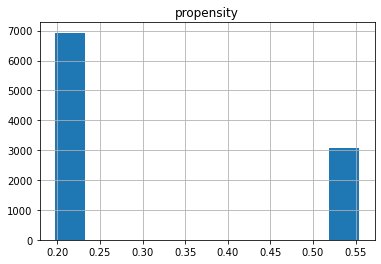

In [14]:
# There are 2 groups of propensity scores (obviously)
df.hist("propensity")
pass

In [15]:
# Define the 2 groups as high and low propensity
high_propensity = df[df["propensity"]==p_treated_smokers]
low_propensity = df[df["propensity"]==p_treated_non_smokers]

# Compute percentage in each propensity group
counts = np.array([len(low_propensity),len(high_propensity)])
percentages= counts / np.sum(counts)
percentages

array([0.693, 0.307])

In [16]:
low_propensity_treated = low_propensity[low_propensity["treatment"]==1]
low_propensity_untreated = low_propensity[low_propensity["treatment"]==0]
ATE_low_propensity = low_propensity_treated["dead"].mean()-low_propensity_untreated["dead"].mean()
ATE_low_propensity

0.02865655916038369

In [17]:
high_propensity_treated = high_propensity[high_propensity["treatment"]==1]
high_propensity_untreated = high_propensity[high_propensity["treatment"]==0]
ATE_high_propensity = high_propensity_treated["dead"].mean()-high_propensity_untreated["dead"].mean()
ATE_high_propensity

-0.30165491578535053

In [18]:
# Find the weighted average across both groups (less biased)

ATE3 = percentages[0] * ATE_low_propensity + percentages[1] * ATE_high_propensity
print('ATE=',ATE3)

# NOTE: Theoretical ATE given the generating function for the random variables is 0.083

ATE= -0.07274906364795672


# 2. Using Logistic Regression to estimate Propensity Scores for problem with multiple confounders
- Example is based on Vanderbilt Right Heart Cathetherization Dataset
- Dataset description: https://biostat.app.vumc.org/wiki/pub/Main/DataSets/Crhc.html

In [19]:
rhc=pd.read_csv('rhc.csv')

In [20]:
rhc.columns



Index(['Unnamed: 0', 'cat1', 'cat2', 'ca', 'sadmdte', 'dschdte', 'dthdte',
       'lstctdte', 'death', 'cardiohx', 'chfhx', 'dementhx', 'psychhx',
       'chrpulhx', 'renalhx', 'liverhx', 'gibledhx', 'malighx', 'immunhx',
       'transhx', 'amihx', 'age', 'sex', 'edu', 'surv2md1', 'das2d3pc',
       't3d30', 'dth30', 'aps1', 'scoma1', 'meanbp1', 'wblc1', 'hrt1', 'resp1',
       'temp1', 'pafi1', 'alb1', 'hema1', 'bili1', 'crea1', 'sod1', 'pot1',
       'paco21', 'ph1', 'swang1', 'wtkilo1', 'dnr1', 'ninsclas', 'resp',
       'card', 'neuro', 'gastr', 'renal', 'meta', 'hema', 'seps', 'trauma',
       'ortho', 'adld3p', 'urin1', 'race', 'income', 'ptid'],
      dtype='object')

In [21]:
rhc.head()

,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,1,COPD,NaN,Yes,11142,11151.0,NaN,11382,No,0,...,No,No,No,No,No,0.0,NaN,white,Under $11k,5
1,2,MOSF w/Sepsis,NaN,No,11799,11844.0,11844.0,11844,Yes,1,...,No,No,Yes,No,No,NaN,1437.0,white,Under $11k,7
2,3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143.0,NaN,12400,No,0,...,No,No,No,No,No,NaN,599.0,white,$25-$50k,9
3,4,ARF,NaN,No,11146,11183.0,11183.0,11182,Yes,0,...,No,No,No,No,No,NaN,NaN,white,$11-$25k,10
4,5,MOSF w/Sepsis,NaN,No,12035,12037.0,12037.0,12036,Yes,0,...,No,No,No,No,No,NaN,64.0,white,Under $11k,11


In [22]:
rhc=rhc.replace(to_replace = 'Yes', value = 1)
rhc=rhc.replace(to_replace = 'No', value = 0)

In [23]:
# Treatment variable: swang1. How many received treatment? 
rhc['swang1'].value_counts(normalize=True)

No RHC    0.61918
RHC       0.38082
Name: swang1, dtype: float64

In [24]:
rhc['treated'] = 0
rhc['treated'] = rhc['treated'].where(rhc.swang1=='No RHC',1)

In [25]:
# Percentage died in the treatment group (percent)
rhc.groupby('treated')['death'].mean()

treated
0    0.629682
1    0.680403
Name: death, dtype: float64

## 2.1 Logistic Regression on the Outcomes and Treatment. For Propensity Score, estimate LR model on the Treatment

In [26]:
# Logistic regression for death (outcome) as dependent variable
model = 'death ~ age + sex + edu + treated'
reg_results = smf.logit(formula=model, data=rhc).fit()
reg_results.summary()

Optimization terminated successfully.
         Current function value: 0.622953
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  death   No. Observations:                 5735
Model:                          Logit   Df Residuals:                     5730
Method:                           MLE   Df Model:                            4
Date:                Thu, 21 Jul 2022   Pseudo R-squ.:                 0.03875
Time:                        00:44:26   Log-Likelihood:                -3572.6
converged:                       True   LL-Null:                       -3716.7
Covariance Type:            nonrobust   LLR p-value:                 4.112e-61
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.2474      0.168     -7.406      0.000      -1.577      -0.917
sex[T.Male]     0.1074      0.057      1.878      0.060      -0.005       0.219
age             0.0277      0.002     15.970      0.000       0.024       0.031
edu             0.0030      0.009      0.327      0.743      -0.015       0.021
treated         0.2526      0.059      4.278      0.000       0.137       0.368
===============================================================================
"""

In [27]:
rhc['sex'] = rhc['sex'].replace('Male', 0)
rhc['sex'] = rhc['sex'].replace('Female', 1)

In [28]:
# Logistic regression with Treatment as dependent variable (Propensity score)
model = 'treated ~ age + sex +edu'
propensity = smf.logit(formula=model, data = rhc).fit()
propensity.summary()

# Fit is very poor - this is just a demo as there are many potential confounders in the dataset that can be used

Optimization terminated successfully.
         Current function value: 0.662209
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                treated   No. Observations:                 5735
Model:                          Logit   Df Residuals:                     5731
Method:                           MLE   Df Model:                            3
Date:                Thu, 21 Jul 2022   Pseudo R-squ.:                0.003394
Time:                        00:44:26   Log-Likelihood:                -3797.8
converged:                       True   LL-Null:                       -3810.7
Covariance Type:            nonrobust   LLR p-value:                 1.017e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5584      0.157     -3.550      0.000      -0.867      -0.250
age           -0.0027      0.002     -1.648      0.099      -0.006       0.001
sex           -0.1858      0.055     -3.374      0.001      -0.294      -0.078
edu            0.0273      0.009      3.111      0.002       0.010       0.045
==============================================================================
"""

In [29]:
# Estimate propensity score and add to the rhc dataframe
rhc['propensity'] = propensity.predict()

# 2.2 Check the distribution of subjects across variables

treated
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: propensity, dtype: object

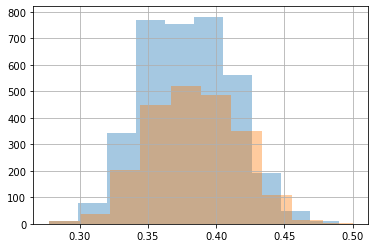

In [30]:
# plot propensity score to compare treated and untreated before matching
rhc.groupby('treated')['propensity'].hist(alpha=0.4)

In [31]:
rhc.groupby('treated')['propensity'].mean()

treated
0    0.379108
1    0.383603
Name: propensity, dtype: float64

In [32]:
# Distributions in the treated and untreated groups
rhc.groupby('treated')['age', 'sex', 'edu'].mean()

<ipython-input-32-f7e7dade26de>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rhc.groupby('treated')['age', 'sex', 'edu'].mean()


,age,sex,edu
treated,,,
0,61.760926,0.460997,11.569005
1,60.749836,0.414835,11.856428


In [33]:
rhc[['age', 'sex', 'edu', 'treated','propensity']].sample(10)

,age,sex,edu,treated,propensity
2155,59.48798,0,11.421669,0,0.399421
3074,50.53799,0,16.000000,0,0.435716
5264,70.02594,0,11.000000,0,0.389840
2033,58.97598,0,12.821571,0,0.408961
1135,47.17599,1,14.000000,1,0.379935
926,65.23999,0,16.000000,0,0.425934
5514,41.43698,1,18.000000,0,0.409745
3080,59.98898,0,12.821571,1,0.408297
598,77.17694,0,8.436928,1,0.368797
2342,66.77899,1,12.000000,1,0.354886


Overview before matching


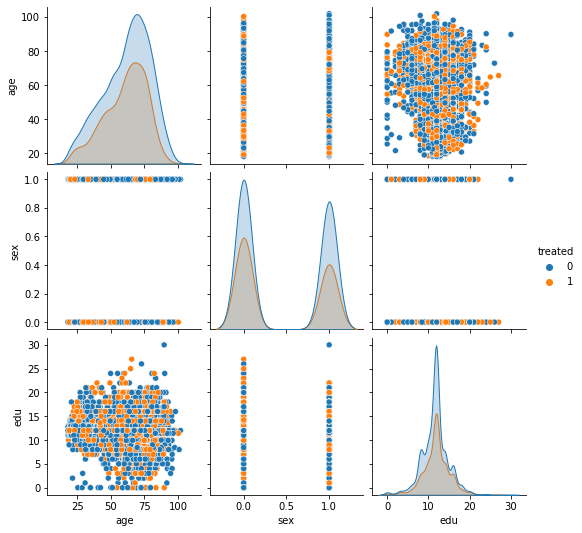

In [34]:
sns.pairplot(data = rhc[['age', 'sex', 'edu', 'treated']], hue = 'treated')
print('Overview before matching')

# 2.3 Simple matching based on Rounding

In [35]:
# Matching based on rounding to first d.p
rhc['group'] = (rhc['propensity']*10).astype(int)

In [36]:
# percentages who die in the different groups
rhc.groupby('group')['death'].mean()

group
2    0.695652
3    0.670981
4    0.595983
5    1.000000
Name: death, dtype: float64

In [37]:
# distinguish between treated and untreated in the different groups and see percentage who die
ps_table=rhc.groupby(['group', 'treated'])['death'].mean().unstack('treated')
ps_table


treated,0,1
group,,
2,0.538462,0.900000
3,0.649882,0.707317
4,0.579317,0.619799
5,NaN,1.000000


In [38]:
rhc_small=rhc[['age', 'sex', 'edu', 'treated','propensity','group','death']]

In [39]:
# Group 5 will not have matches for treated and untreated, so it is dropped
treated = rhc_small.loc[(rhc_small["treated"]==1) & (rhc_small['group']!=5),:]
untreated = rhc_small.loc[(rhc_small["treated"]==0) & (rhc_small['group']!=5),:]

In [40]:
# matching by groups
treated = treated.reset_index(drop=True)
matched_control=[]

def add_matched_control(patient):
    control_patient = untreated[untreated["group"]==patient["group"]].sample().iloc[0]
    matched_control.append(control_patient)

treated.apply(add_matched_control, axis=1)
matched_control_df = pd.DataFrame(matched_control).reset_index(drop=True)
paired_sample = treated.join(matched_control_df, rsuffix="_control")
paired_sample

,age,sex,edu,treated,propensity,group,death,age_control,sex_control,edu_control,treated_control,propensity_control,group_control,death_control
0,78.17896,1,12.000000,1,0.347837,3,1,50.39600,1.0,12.000000,0.0,0.365127,3.0,0.0
1,46.09198,1,14.069916,1,0.381078,3,0,76.43500,0.0,12.000000,0.0,0.392202,3.0,1.0
2,67.90997,0,9.945259,1,0.384368,3,1,81.27295,1.0,12.000000,0.0,0.345935,3.0,1.0
3,48.42398,1,11.040535,1,0.360308,3,0,76.75299,1.0,8.436928,0.0,0.326954,3.0,1.0
4,68.34796,0,12.000000,1,0.397444,3,0,71.05798,1.0,12.000000,0.0,0.352233,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,42.90500,0,11.040535,1,0.407746,4,1,83.32397,0.0,23.000000,0.0,0.460988,4.0,1.0
2179,74.89697,0,9.945259,1,0.379892,3,1,34.87500,0.0,0.000000,0.0,0.342313,3.0,1.0
2180,69.92694,1,9.000000,1,0.334457,3,1,76.13397,0.0,8.000000,0.0,0.366680,3.0,0.0
2181,79.21698,1,8.000000,1,0.322870,3,0,68.40198,1.0,12.000000,0.0,0.353879,3.0,0.0


# 2.4 Step 5: Check the balance of covariates in the exposed and unexposed groups after matching on PS using subclassification

In [41]:
# Check distribution in the treated and untreated groups given (age, edu etc in the different groups)
cov=rhc.groupby(['group', 'treated'])['age', 'sex', 'edu'].mean().unstack('treated')
cov.dropna(inplace=True)
cov

<ipython-input-41-d0c496721373>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cov=rhc.groupby(['group', 'treated'])['age', 'sex', 'edu'].mean().unstack('treated')


age                  sex                  edu           
treated          0          1         0         1          0          1
group                                                                  
2        79.668124  70.251468  1.000000  1.000000   2.846154   1.700000
3        66.084293  64.332149  0.619591  0.590786  10.725295  10.819763
4        50.493061  53.020573  0.049197  0.034433  13.836182  14.175709

In [42]:
# overall group average
cov_avg=rhc.groupby(['group', 'treated'])['age', 'sex', 'edu'].mean().unstack('treated').mean()
cov_avg

<ipython-input-42-5bd86190f4d7>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cov_avg=rhc.groupby(['group', 'treated'])['age', 'sex', 'edu'].mean().unstack('treated').mean()


     treated
age  0          65.415159
     1          63.285035
sex  0           0.556263
     1           0.406305
edu  0           9.135877
     1          13.423868
dtype: float64

In [43]:
# Melt dataframe to plot the comparison of distribution in covariates after matching
paired_sample_treated=paired_sample[['age', 'sex', 'edu', 'treated', 'propensity', 'group','death']]
paired_sample_untreated=paired_sample[['age_control',
       'sex_control', 'edu_control', 'treated_control', 'propensity_control',
       'group_control','death_control']]
paired_sample_untreated.columns = ['age', 'sex', 'edu', 'treated', 'propensity', 'group','death']
paired_sample_long=pd.concat([paired_sample_treated,paired_sample_untreated],ignore_index=True, sort=False)
paired_sample_long

,age,sex,edu,treated,propensity,group,death
0,78.17896,1.0,12.000000,1.0,0.347837,3.0,1.0
1,46.09198,1.0,14.069916,1.0,0.381078,3.0,0.0
2,67.90997,0.0,9.945259,1.0,0.384368,3.0,1.0
3,48.42398,1.0,11.040535,1.0,0.360308,3.0,0.0
4,68.34796,0.0,12.000000,1.0,0.397444,3.0,0.0
...,...,...,...,...,...,...,...
4361,83.32397,0.0,23.000000,0.0,0.460988,4.0,1.0
4362,34.87500,0.0,0.000000,0.0,0.342313,3.0,1.0
4363,76.13397,0.0,8.000000,0.0,0.366680,3.0,0.0
4364,68.40198,1.0,12.000000,0.0,0.353879,3.0,0.0


Overview after matching


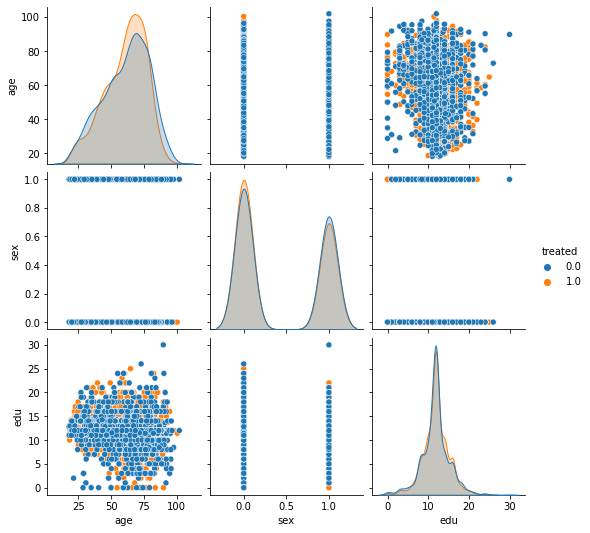

In [44]:
sns.pairplot(data = paired_sample_long[['age', 'sex', 'edu', 'treated']], hue = 'treated')
print('Overview after matching')

In [45]:
matched_ps_table=paired_sample_long.groupby(['group', 'treated'])['death'].mean().unstack('treated')
matched_ps_table

treated,0.0,1.0
group,,
2.0,0.700000,0.900000
3.0,0.652439,0.707317
4.0,0.572453,0.619799


In [46]:
# Evaluate treatment differences for each group
matched_ps_table['difference'] = matched_ps_table[1] - matched_ps_table[0]
matched_ps_table

treated,0.0,1.0,difference
group,,,
2.0,0.700000,0.900000,0.200000
3.0,0.652439,0.707317,0.054878
4.0,0.572453,0.619799,0.047346


In [48]:
# End result, average effect of treatment(ATE) on mortality across all groups
matched_ps_table['difference'].mean()

0.10074127211860351